In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('Sunspots.csv',index_col='Date',parse_dates=True) #C:\Users\deeks\OneDrive\Desktop\PROJECT\
df.index.freqs='MS' 

In [3]:
display(df)

,Unnamed: 0,Monthly Mean Total Sunspot Number
Date,,
1749-01-31,0,96.7
1749-02-28,1,104.3
1749-03-31,2,116.7
1749-04-30,3,92.8
1749-05-31,4,141.7
...,...,...
2020-09-30,3260,0.6
2020-10-31,3261,14.4
2020-11-30,3262,34.0


In [4]:
df.shape
#Ouput(rows, columns(features))

(3265, 2)

In [5]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
    X,y =[],[]
    for i in range(len(timeseries_data)):
        #find the end of this pattern
        end_ix = i + n_features
        #check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
            

Processing the data

In [6]:
import csv

# Processing and preparing the data
time_step = []
sunspots = []

with open('Sunspots.csv') as csvfile:  
    reader = csv.reader(csvfile, delimiter=',')  #C:\Users\deeks\OneDrive\Desktop\PROJECT\
    next(reader) # the next() function skips the first line (header) when looping
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

In [7]:
# For plotting the series or data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    myplot = plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time (Months)")
    plt.ylabel("Average Monthly Sunpots")
    if label != None:
        plt.legend()
    plt.grid(True)

Before plotting, the data gets converted to Numpy arrays

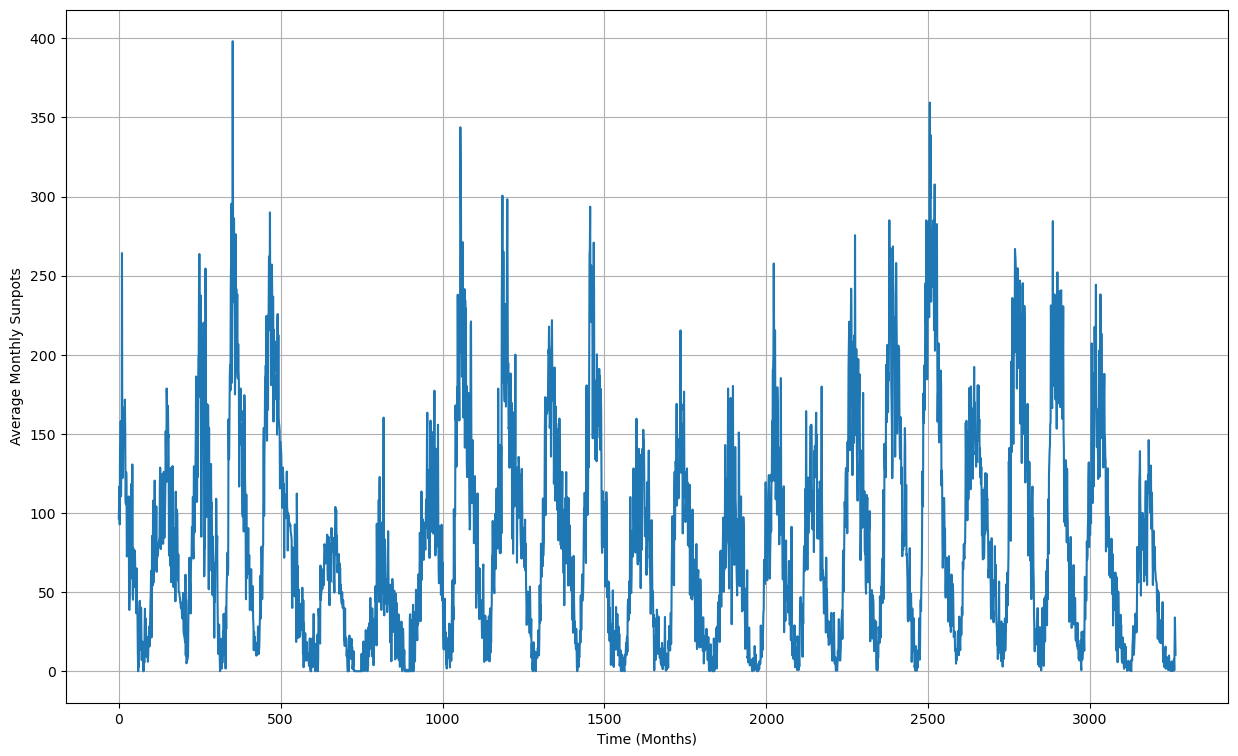

In [8]:
series = np.array(sunspots)
time = np.array(time_step)
#Looking at the data
plt.figure(figsize=(15, 9))
plot_series(time, series)

Pre-Processing

In [9]:
# Adjusting the parameters & preparing the Model
split_time = 3000
window_size= 30
batch_size = 32
shuffle_buffer_zone = 1000

# Training data
train_time = time[:split_time]
X_train = series[:split_time]
# Validation data
valid_time = time[split_time:]
X_valid = series[split_time:]
     

Graphing help us understanding the split better

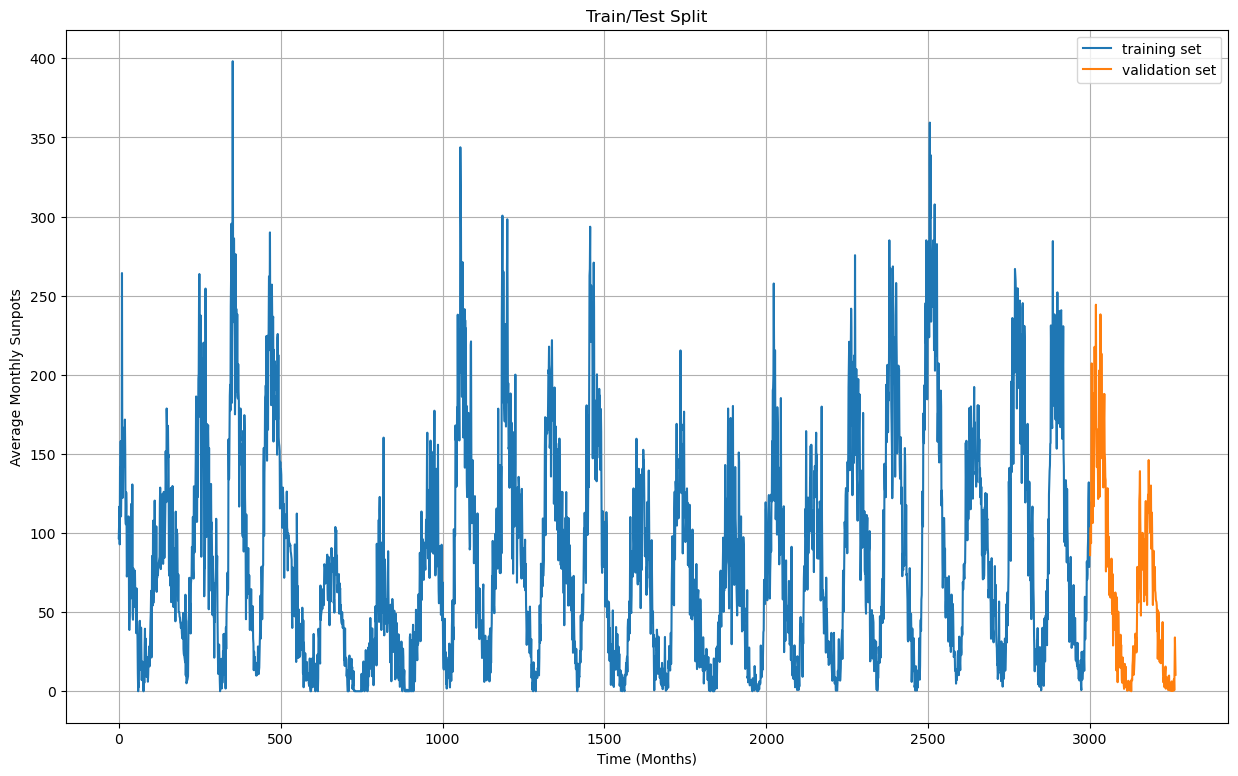

In [10]:
plt.figure(figsize=(15, 9))
plt.title("Train/Test Split")
plot_series(train_time, X_train, label="training set")
plot_series(valid_time, X_valid, label="validation set")

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

To demonstrate how the windowed_dataset function and the window_size parameter are slicing the data set, have a closer look at the graph below.

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

Train for Learning-Rate Optimization

In [22]:
import tensorflow as tf


tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
shuffle_buffer_zone = 1000
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_zone)
print(train_set)
print(X_train.shape)

model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
  ])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

#Compiling the Model
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# Fitting the Model
history = model.fit(train_set, epochs=60, callbacks=[lr_schedule])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(3000,)
Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 152.5640 - mae: 153.0632 - learning_rate: 1.0000e-08
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - loss: 117.7510 - mae: 118.2502 - learning_rate: 1.1220e-08
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - loss: 105.5772 - mae: 106.0766 - learning_rate: 1.2589e-08
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 101.7157 - mae: 102.2152 - learning_rate: 1.4125e-08
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 98.3414 - mae: 98.8411 - learning_rate: 1.5849e-08
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 95.1800 - mae: 95.6797 - learning_rate: 1.7783e-08
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - loss: 92.9085 - mae: 93.4082 - learning_rate: 1.9953e-08
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms

101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
First 10 Predictions : 
 [124.7953   119.94877  120.965065 122.94566  121.31822  135.59511
 154.67325  162.10504  161.70918  153.00653 ]

mae :  14.927265188918923


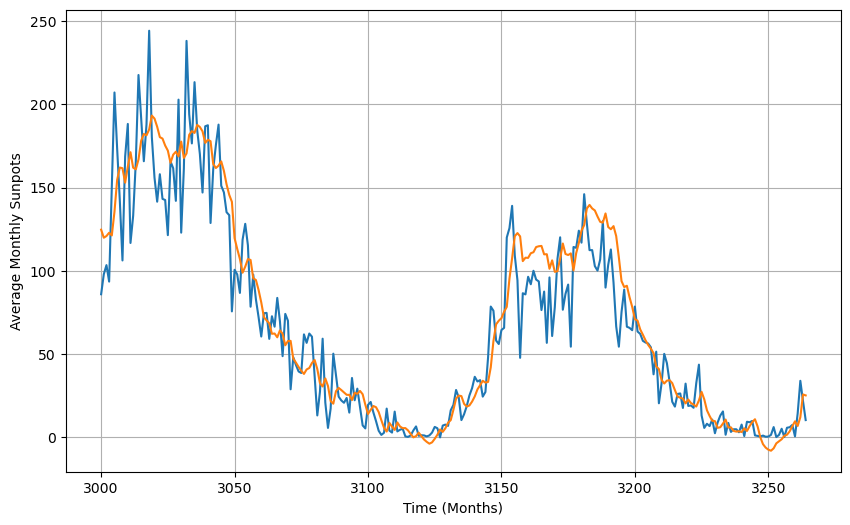

In [23]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

print("First 10 Predictions :","\n", rnn_forecast[:10])
print('')

mae = tf.reduce_mean(tf.abs(X_valid - rnn_forecast)).numpy()
print("mae : ", mae)

plt.figure(figsize=(10, 6))
plot_series(valid_time, X_valid)
plot_series(valid_time, rnn_forecast)

Forecasting and Evaluating
Here, we see the last sun-spot cycle and how the model (orange) at least visually matches the training/validation (blue) data quite well.

In [24]:
# Calculating the mean absolute error
print('Mean Absolute Error (MAE): ',tf.reduce_mean(tf.abs(X_valid - rnn_forecast)).numpy())

Mean Absolute Error (MAE):  14.927265188918923


In [25]:
for i in range(10,20):
    print(X_valid[i], " - ", rnn_forecast[i])

188.3  -  162.72095
116.8  -  171.33322
133.1  -  162.01796
165.7  -  161.04053
217.7  -  166.98186
191.5  -  178.1829
165.9  -  182.27797
188.0  -  181.45499
244.3  -  185.00984
180.5  -  193.32568


In [26]:
print(X_valid.shape)
print(rnn_forecast.shape)

from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(X_valid,rnn_forecast)
print("mse = ", mse)
rmse=sqrt(mse)
print("rmse = ", rmse)

(265,)
(265,)
mse =  439.32758688435996
rmse =  20.96014281641134


In [27]:
# Define the number of future time steps to forecast
future_steps = 100

# Function to generate forecasts
def generate_forecasts(model, series, window_size, future_steps):
    # Create a copy of the series to hold the forecasted values
    forecast_series = series.copy()
    
    # Iterate over the number of future steps to forecast
    for step in range(future_steps):
        # Extract the most recent window from the series
        recent_window = forecast_series[-window_size:]
        
        # Reshape the window to match the input shape expected by the model
        recent_window = recent_window.reshape(1, -1, 1)
        
        # Predict the next value using the model
        next_value = model.predict(recent_window)[0, -1, 0]
        
        # Append the predicted value to the forecast series
        forecast_series = np.append(forecast_series, next_value)
    
    return forecast_series

# Generate forecasts using the trained model and the training set
train_forecasts = generate_forecasts(model, X_train, window_size, future_steps)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

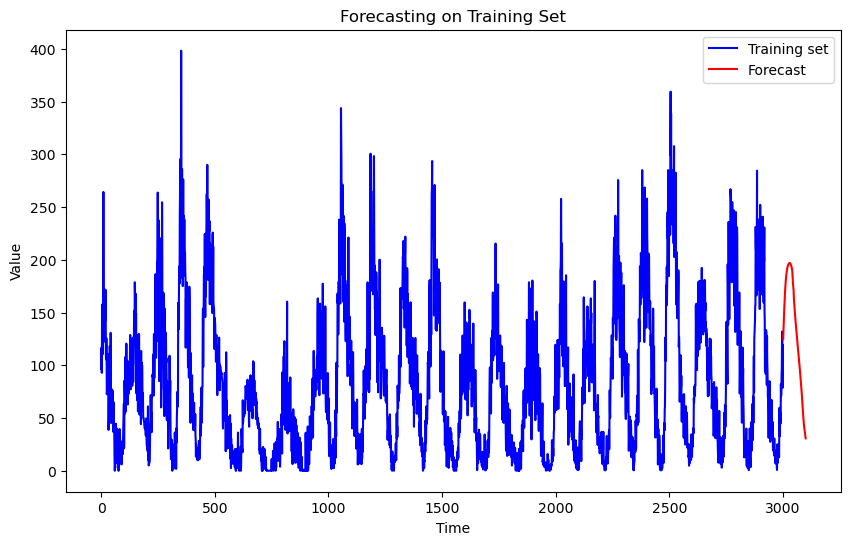

In [28]:
# Plot the original series and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time[:len(X_train)], X_train, label='Training set', color='blue')
plt.plot(time[len(X_train):len(X_train)+future_steps], train_forecasts[-future_steps:], label='Forecast', color='red')
plt.title('Forecasting on Training Set')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()